In [1]:
import pandas as pd
import numpy as np
import sys
import jsonpickle as jp
import matplotlib.pyplot as plt
import logging
from collections import defaultdict
import jsonpickle


sys.path.append(r"/Users/ysc/Desktop/imcProsperity/utils")

import datamodel
import simulator

pd.options.mode.chained_assignment = None


In [2]:
import datamodel
from datamodel import OrderDepth, UserId, TradingState, Order
import jsonpickle


class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20
    }

    attributes = {}

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0

        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        if total_volume == 0:
            return -1
        else:
            return wavg_price / total_volume

    @staticmethod
    def calculate_barrier_price(order_depth, mid, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if p >= mid:
                continue
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            if p <= mid:
                continue
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > sell_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, buy_vol_, sell_p_, sell_vol_

    @staticmethod
    def hit_the_book(product, order_depth, buy_capacity, buy_price, sell_capacity, sell_price):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        orders = []
        for p, vol in sorted_buy_orders:
            vol = abs(vol)
            if p >= sell_price:
                if p == 10000:
                    s_amt = min(sell_capacity, vol, 5)
                else:
                    s_amt = min(sell_capacity, vol)
                if s_amt > 0:
                    sell_capacity -= s_amt
                    orders.append(Order(product, p, -s_amt))
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if p <= buy_price:
                if p == 10000:
                    b_amt = min(buy_capacity, vol, 5)
                b_amt = min(buy_capacity, vol)
                if b_amt > 0:
                    buy_capacity -= b_amt
                    orders.append(Order(product, p, b_amt))
        return orders, buy_capacity, sell_capacity

    def run(self, state):

        result = {}
        idx = state.timestamp // 100

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            sell_capacity = self.LIMIT[product] + current_position
            buy_capacity = self.LIMIT[product] - current_position
            orders = []

            if product == "AMETHYSTS":

                buy_shift = 1 if buy_capacity <= 5 else 0
                sell_shift = 1 if sell_capacity <= 5 else 0
                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, 9999 + buy_shift,
                                                                         sell_capacity, 10001 - sell_shift)
                orders.extend(_orders)

                ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume = self.calculate_barrier_price(order_depth, 10000, 1)
                sell_price, buy_price = max(10001, ext_sell_price - 1), min(9999, ext_buy_price + 1)

                if sell_capacity > 0:
                    orders.append(Order(product, sell_price, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, buy_price, buy_capacity))

            elif product == "STARFRUIT":

                prev_price = self.attributes.get("starfruit_price", None)
                if idx == 0:
                    prev_price = self.calculate_wavg_midprice(order_depth)
                elif idx != 0 and prev_price is None:
                    self.attributes = jsonpickle.decode(state.traderData)
                    prev_price = self.attributes.get("starfruit_price", None)

                ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume \
                    = self.calculate_barrier_price(order_depth, prev_price, 15)

                low = None if ext_buy_volume < 15 else ext_buy_price
                top = None if ext_sell_volume < 15 else ext_sell_price

                if top is None and low is None:
                    cur_price = prev_price
                    if cur_price != int(cur_price):
                        top = int(cur_price + 3.5)
                        low = int(cur_price - 3.5)
                    else:
                        top = int(cur_price + 4)
                        low = int(cur_price - 4)
                elif top is None:
                    cur_price = low + 3.5
                    top = low + 7
                elif low is None:
                    cur_price = top - 3.5
                    low = top - 7
                else:
                    cur_price = (low + top) / 2

                self.attributes['starfruit_price'] = cur_price

                if sell_capacity <= 10:
                    sell_margin, buy_margin = 1, 0.5
                elif buy_capacity <= 10:
                    sell_margin, buy_margin = 0.5, 1
                else:
                    sell_margin, buy_margin = 1, 1
                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, cur_price - buy_margin,
                                                                         sell_capacity, cur_price + sell_margin)
                orders.extend(_orders)

                buy_price = low + 1
                if sell_capacity <= 10 and order_depth.buy_orders.get(buy_price, 0) >= 3:
                    buy_price += 1
                sell_price = top - 1
                if buy_capacity <= 10 and order_depth.sell_orders.get(sell_price, 0) >= 3:
                    sell_price -= 1

                if sell_capacity > 0:
                    orders.append(Order(product, sell_price, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, buy_price, buy_capacity))

            result[product] = orders

        trader_data = jsonpickle.encode(self.attributes)

        return result, None, trader_data

 -> AMETHYSTS: 7592.0
 -> STARFRUIT: 5829.5
 -> total: 13421.5


# of transaction is 3030
 -> AMETHYSTS: B(809) + S(811)
 -> STARFRUIT: B(546) + S(864)


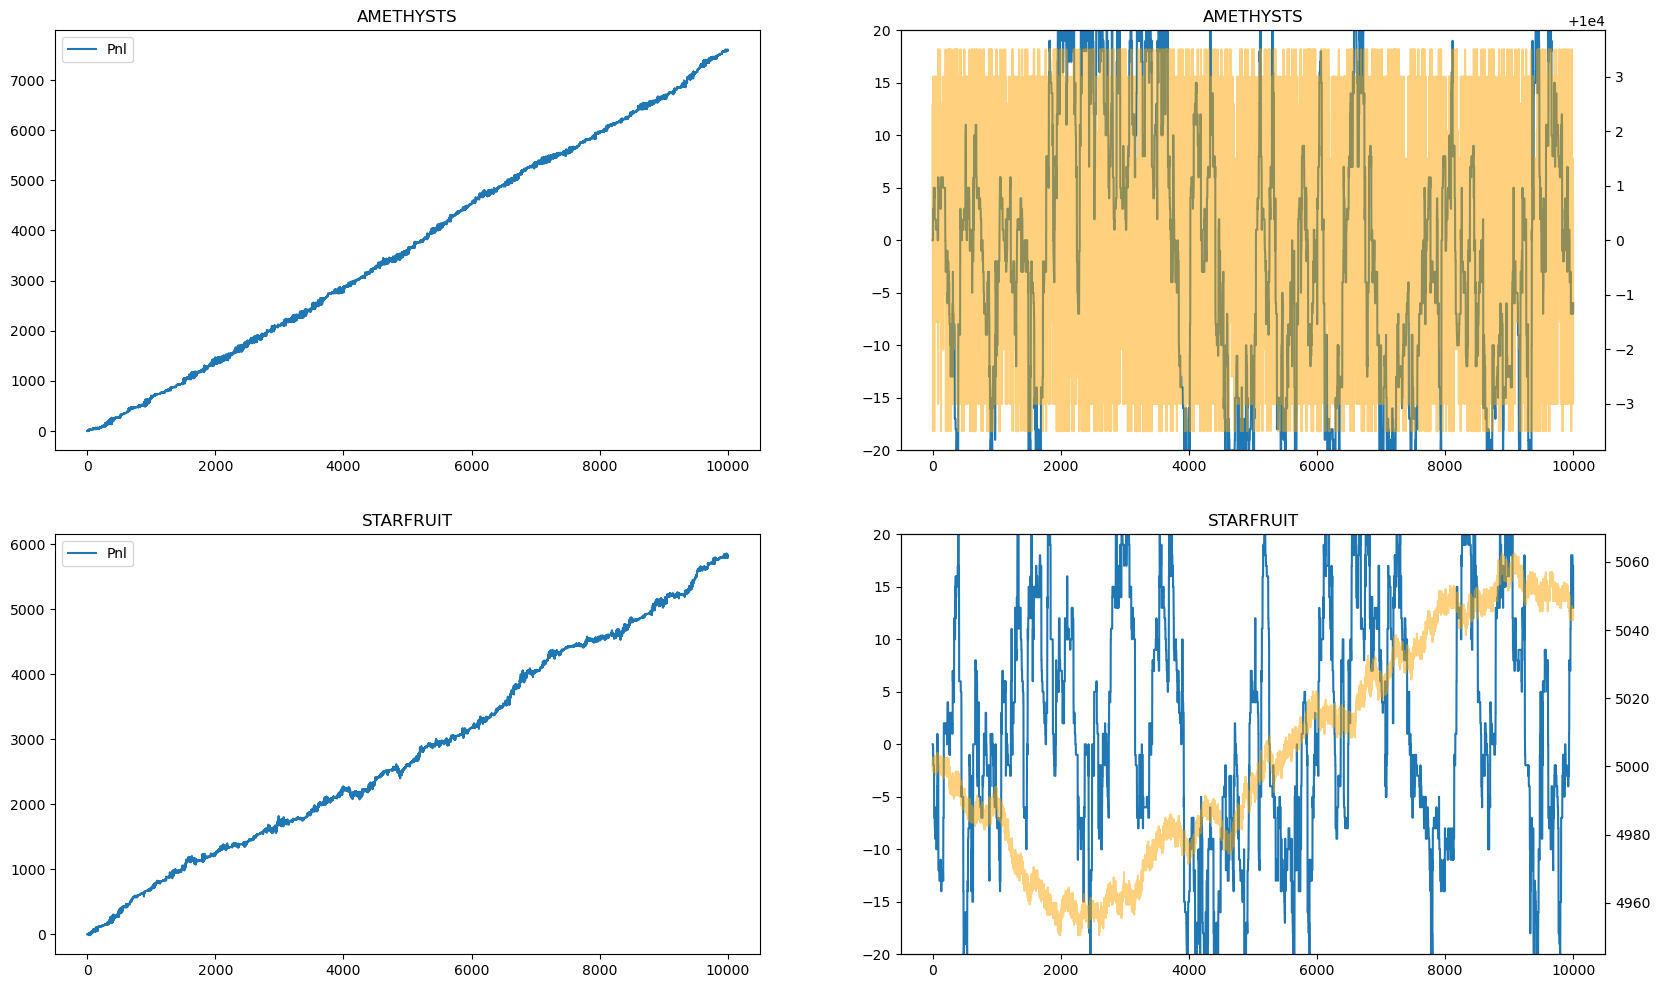

In [3]:
day = -2
# simulator = Simulator(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv")
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv", sep=';')[:20000]
sim = simulator.Simulator(df=df)
trader1 = Trader()
res = sim.simulate(trader1)
res.summary(verbose=True)

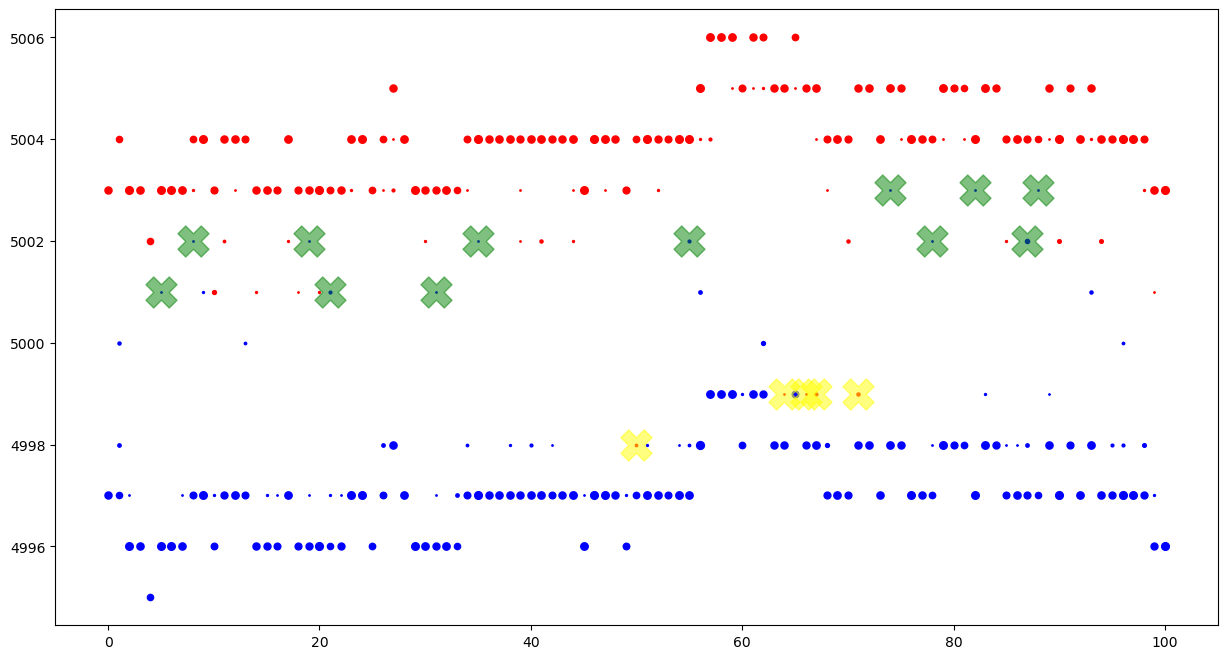

In [1023]:
M, N = 0, 100
product = "STARFRUIT"

fig, ax = plt.subplots(figsize=(15, 8))
for _, row in df[df['product'] == product].iterrows():
    idx = row['timestamp'] // 100
    if idx < M:
        continue
    if idx > N:
        break

    for i in (1, 2, 3):
        if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
            ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])

    for i in (1, 2, 3):
        if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
            ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])


for _, row in res.transactions[res.transactions['Product'] == product].iterrows():
    idx = row['TimeStamp'] // 100
    if idx < M:
        continue
    if idx > N:
        break
    if row['B/S'] == "B":
        ax.scatter(idx, row['Price'], c='yellow', marker='X', alpha=0.5, s=500)
    else:
        ax.scatter(idx, row['Price'], c='green', marker='X', alpha=0.5, s=500)

In [948]:
day = 0
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round2/data/prices_round_2_day_{day}.csv", sep=';')

# df = df.iloc[7000:9000, :]

df['TOTAL_COST'] = df['TRANSPORT_FEES'] + df['EXPORT_TARIFF'] - df['IMPORT_TARIFF']
df['TOTAL_COST2'] = df['TRANSPORT_FEES'] + df['EXPORT_TARIFF'] + df['IMPORT_TARIFF']

def normalize(col):
    max_, min_ = max(col), min(col)
    return (col - min_) / (max_ - min_) 

for col in ("TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"):
    df[f"{col}_n"] = normalize(df[col])

def direction(vt):
    res = [0]
    for x1, x2 in zip(vt[:-1], vt[1:]):
        res.append(--(x2 - x1 < 0))
    return res

dir = direction(df['HUMIDITY'])

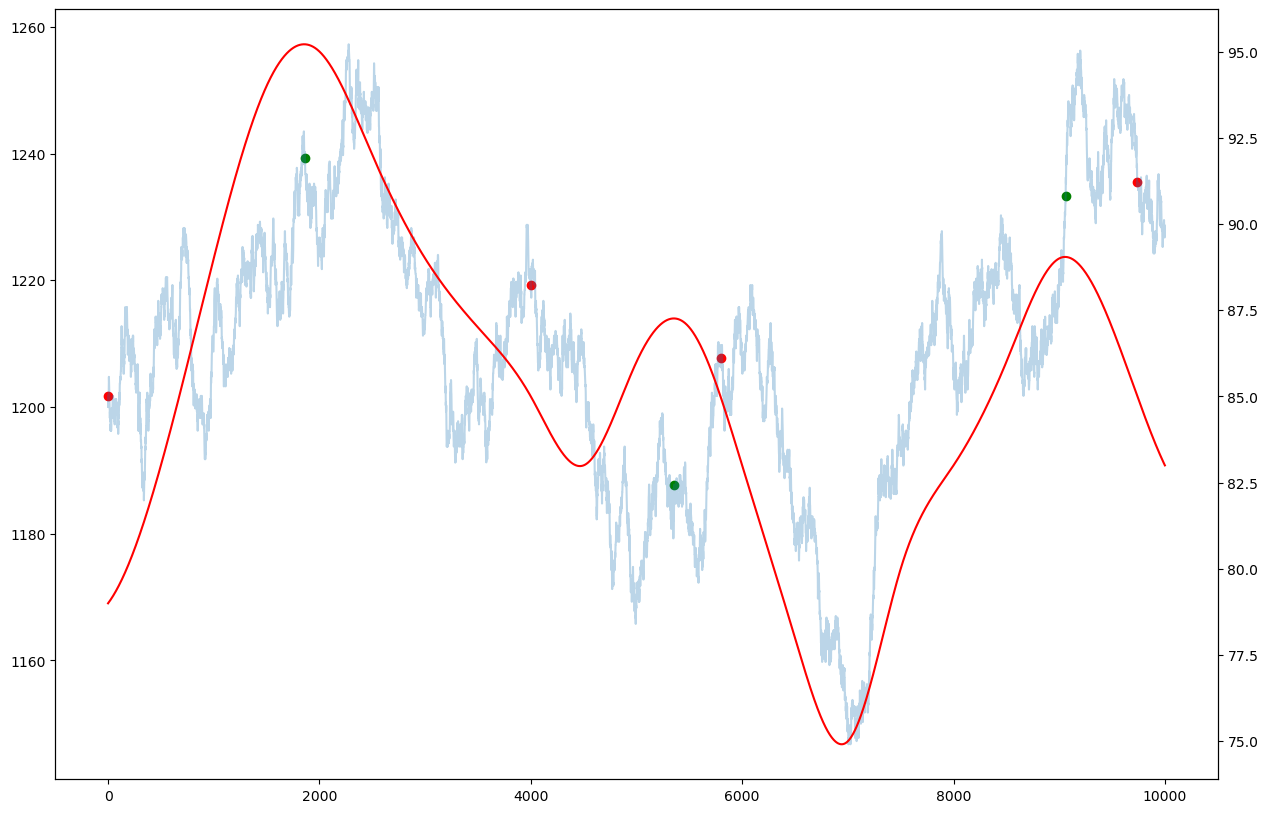

In [962]:
def test(vt, n=5):
    dir = [0]
    for x1, x2 in zip(vt[:-1], vt[1:]):
        if x2 - x1 > 0:
            dir += [1]
        elif x2 - x1 < 0:
            dir += [-1]
        else:
            dir += [0]

    dir = np.array(dir)

    order = {}
    prev = None
    for i in range(len(vt)):
        if i >= n - 1:
            if (dir[i-n+1:i+1].sum() == n or vt[i] < 85) and prev != 'B':
                order[i] = 'B'
                prev = 'B'
            elif (dir[i-n+1:i+1].sum() == -n and vt[i] >= 85) and prev != 'S':
                order[i] = 'S'
                prev = 'S'

    return order 
    
    

_, ax = plt.subplots(figsize=(15, 10))


# ax.plot([*range(w_ma-1, len(tmp))], ma[~ma.isna()].values)

ax.plot(df["ORCHIDS"], alpha=0.3)
# for c in test2(df['HUMIDITY']):
#     ax.scatter(c, df.loc[c, "ORCHIDS"], c='red')

orders = test(df['HUMIDITY'])
shift = 0
for k, v in orders.items():
    if v == 'B':
        plt.scatter(k+shift, df.loc[k+shift, 'ORCHIDS'], c='red')
    else:
        plt.scatter(k+shift, df.loc[k+shift, 'ORCHIDS'], c='green')

# ax.plot(test(df))
ax2 = ax.twinx()
# ax2.plot(df['ORCHIDS'], c='red')
ax2.plot(df['HUMIDITY'], c='red')



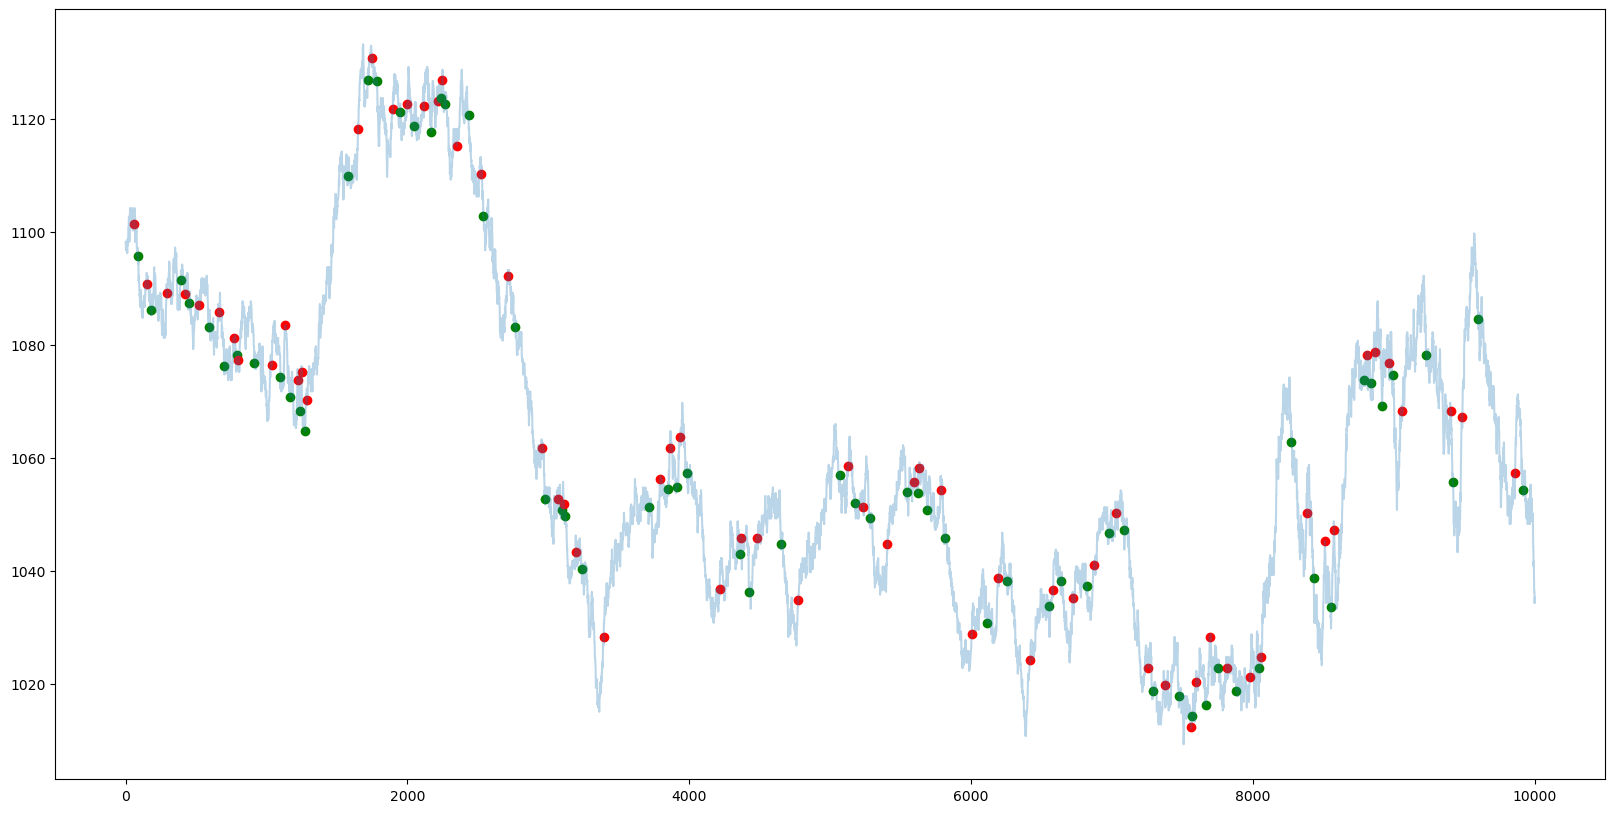

In [943]:
w_ma = 50
ma = df['ORCHIDS'].rolling(w_ma).mean().bfill()
_, ax = plt.subplots(figsize=(20, 10))
# plt.plot(ma.values)

def test(vt, n=10):
    dir = [0]
    for x1, x2 in zip(vt[:-1], vt[1:]):
        if x2 - x1 > 0:
            dir += [1]
        elif x2 - x1 < 0:
            dir += [-1]
        else:
            dir += [0]

    order = {}
    prev = None
    for i in range(len(vt)):
        if i >= n + w_ma:
            if sum(dir[i-n+1:i+1]) >= 0.8 * n and prev != 'B':
                order[i] = 'B'
                prev = 'B'
            elif sum(dir[i-n+1:i+1]) <= -0.8 * n and prev != 'S':
                order[i] = 'S'
                prev = 'S'

    return order 

plt.plot(df['ORCHIDS'], alpha=0.3)
orders = test(ma)
for k, v in orders.items():
    if v == 'B':
        plt.scatter(k, df.loc[k, 'ORCHIDS'], c='red')
    else:
        plt.scatter(k, df.loc[k, 'ORCHIDS'], c='green')


In [989]:
2500 * 10000 * 7 / 12

14583333.333333334

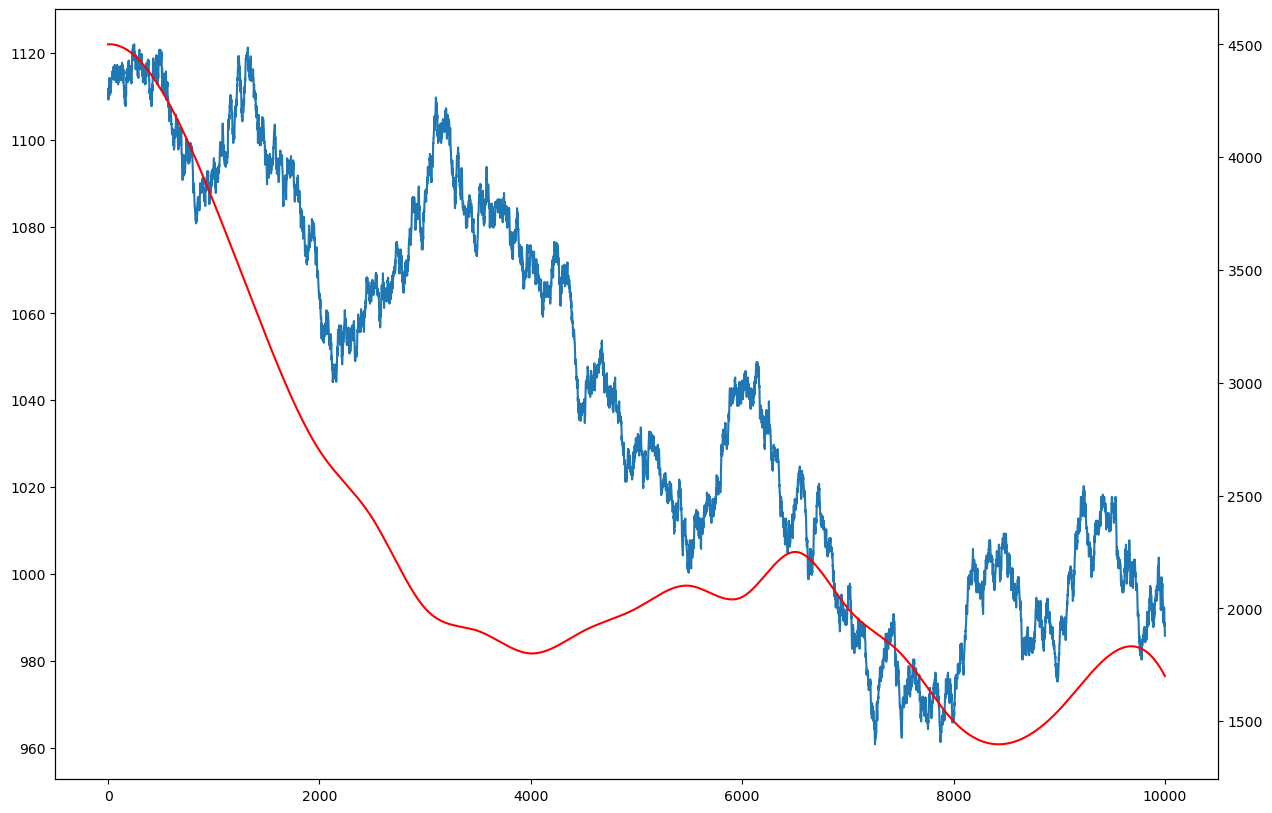

In [1077]:
# tmp = df.loc[df['HUMIDITY'] >= 80, ['HUMIDITY', "ORCHIDS", "SUNLIGHT"]]
day = 0
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round2/data/prices_round_2_day_{day}.csv", sep=';')


tmp = df

f1 = tmp['SUNLIGHT'].cumsum() +  tmp['SUNLIGHT'] * (10000 - tmp.index)

_, ax = plt.subplots(figsize=(15, 10))

ax.plot(tmp['ORCHIDS'])
# ax.plot(tmp['SUNLIGHT'], c='green')

ax2 = ax.twinx()
# ax2.plot(tmp['HUMIDITY'] , c='red')
ax2.plot(tmp['SUNLIGHT'], c='red')
# ax2.plot(f1, c='red')

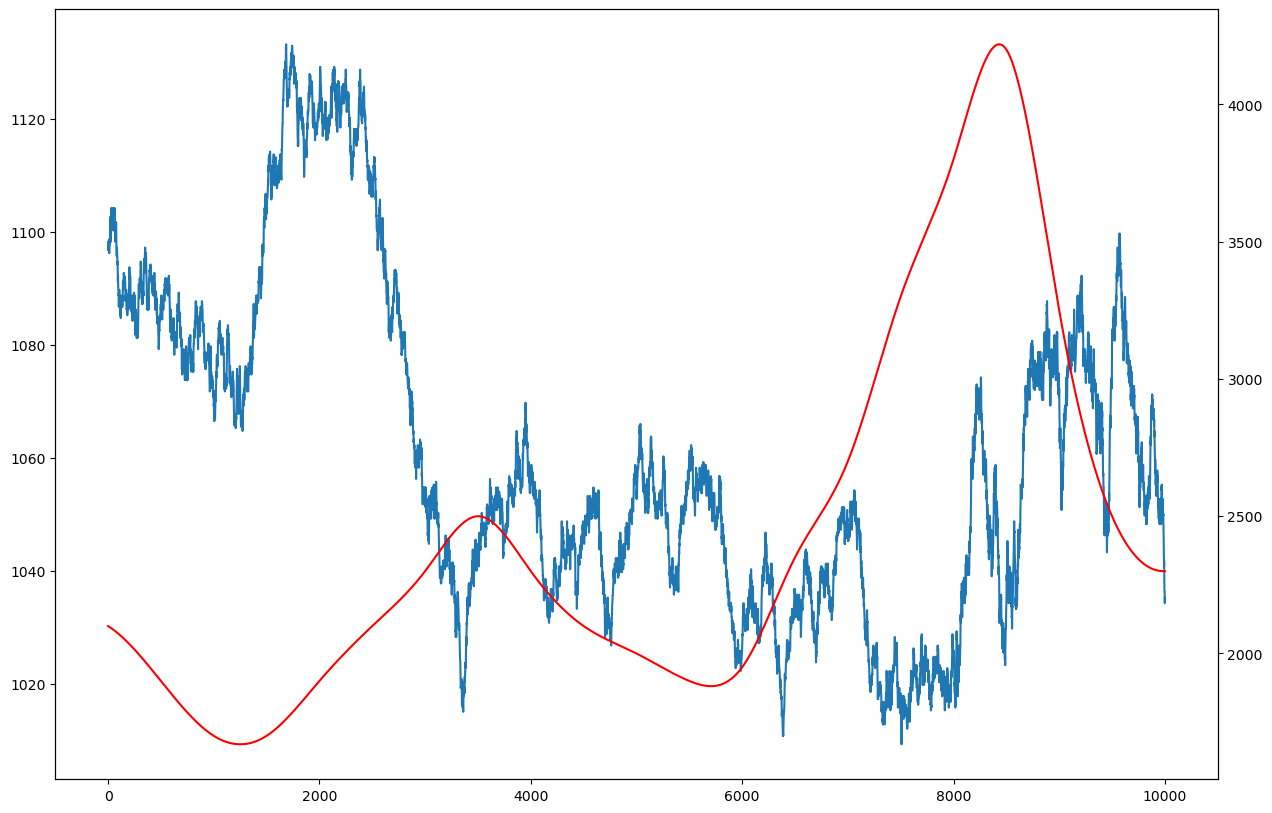

In [1078]:
# tmp = df.loc[df['HUMIDITY'] >= 80, ['HUMIDITY', "ORCHIDS", "SUNLIGHT"]]
day = 1
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round2/data/prices_round_2_day_{day}.csv", sep=';')


tmp = df

f1 = tmp['SUNLIGHT'].cumsum() +  tmp['SUNLIGHT'] * (10000 - tmp.index)

_, ax = plt.subplots(figsize=(15, 10))

ax.plot(tmp['ORCHIDS'])
# ax.plot(tmp['SUNLIGHT'], c='green')

ax2 = ax.twinx()
# ax2.plot(tmp['HUMIDITY'] , c='red')
ax2.plot(tmp['SUNLIGHT'], c='red')
# ax2.plot(f1, c='red')

array([1110.625, 1110.775, 1110.9  , ..., 1071.175, 1070.725, 1070.375])

In [ ]:
import datamodel
from datamodel import OrderDepth, UserId, TradingState, Order
import jsonpickle
import numpy as np


class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20,
        "ORCHIDS": 100
    }
    attributes = {}

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0

        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        if total_volume == 0:
            return -1
        else:
            return wavg_price / total_volume

    @staticmethod
    def calculate_barrier_price(order_depth, mid, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if p >= mid:
                continue
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            if p <= mid:
                continue
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > sell_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, buy_vol_, sell_p_, sell_vol_

    @staticmethod
    def hit_the_book(product, order_depth, buy_capacity, buy_price, sell_capacity, sell_price):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        orders = []
        for p, vol in sorted_buy_orders:
            vol = abs(vol)
            if p >= sell_price:
                s_amt = min(sell_capacity, vol)
                if s_amt > 0:
                    sell_capacity -= s_amt
                    orders.append(Order(product, p, -s_amt))
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if p <= buy_price:
                b_amt = min(buy_capacity, vol)
                if b_amt > 0:
                    buy_capacity -= b_amt
                    orders.append(Order(product, p, b_amt))
        return orders, buy_capacity, sell_capacity

    def simulate_lambda_reset(self):
        self.attributes = {}

    def run(self, state):

        result = {}
        idx = state.timestamp // 100

        # if np.random.uniform(0, 1) >= 0.9:
        #     self.simulate_reset()

        conversions = None

        if idx >= 1 and not self.attributes:
            self.attributes = jsonpickle.decode(state.traderData)

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            sell_capacity = self.LIMIT[product] + current_position
            buy_capacity = self.LIMIT[product] - current_position
            orders = []

            # if product == "AMETHYSTS":
            #
            #     _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
            #                                                              buy_capacity, 9999,
            #                                                              sell_capacity, 10001)
            #     orders.extend(_orders)
            #
            #     ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume = self.calculate_barrier_price(order_depth, 10000, 1)
            #     sell_price, buy_price = max(10001, ext_sell_price - 1), min(9999, ext_buy_price + 1)
            #
            #     if sell_capacity > 0:
            #         orders.append(Order(product, sell_price, -sell_capacity))
            #     if buy_capacity > 0:
            #         orders.append(Order(product, buy_price, buy_capacity))
            #
            # elif product == "STARFRUIT":
            #
            #     prev_price = self.attributes.get("starfruit_price", None)
            #     if idx == 0:
            #         prev_price = self.calculate_wavg_midprice(order_depth)
            #     elif idx != 0 and prev_price is None:
            #         self.attributes = jsonpickle.decode(state.traderData)
            #         prev_price = self.attributes.get("starfruit_price", None)
            #
            #     ext_buy_price, ext_buy_volume, ext_sell_price, ext_sell_volume \
            #         = self.calculate_barrier_price(order_depth, prev_price, 15)
            #
            #     low = None if ext_buy_volume < 15 else ext_buy_price
            #     top = None if ext_sell_volume < 15 else ext_sell_price
            #
            #     if top is None and low is None:
            #         cur_price = prev_price
            #         if cur_price != int(cur_price):
            #             top = int(cur_price + 3.5)
            #             low = int(cur_price - 3.5)
            #         else:
            #             top = int(cur_price + 4)
            #             low = int(cur_price - 4)
            #     elif top is None:
            #         cur_price = low + 3.5
            #         top = low + 7
            #     elif low is None:
            #         cur_price = top - 3.5
            #         low = top - 7
            #     else:
            #         cur_price = (low + top) / 2
            #
            #     self.attributes['starfruit_price'] = cur_price
            #
            #     if sell_capacity <= 5:
            #         sell_margin, buy_margin = 1, 0.5
            #     elif buy_capacity <= 5:
            #         sell_margin, buy_margin = 0.5, 1
            #     else:
            #         sell_margin, buy_margin = 1, 1
            #     _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
            #                                                              buy_capacity, cur_price - buy_margin,
            #                                                              sell_capacity, cur_price + sell_margin)
            #     orders.extend(_orders)
            #
            #     buy_price = low + 1
            #     if sell_capacity <= 5 and order_depth.buy_orders.get(buy_price, 0) >= 3:
            #         buy_price += 1
            #     sell_price = top - 1
            #     if buy_capacity <= 5 and order_depth.sell_orders.get(sell_price, 0) >= 3:
            #         sell_price -= 1
            #
            #     if sell_capacity > 0:
            #         orders.append(Order(product, sell_price, -sell_capacity))
            #     if buy_capacity > 0:
            #         orders.append(Order(product, buy_price, buy_capacity))

            if product == "ORCHIDS":

                bidPrice = state.observations.conversionObservations[product].bidPrice
                askPrice = state.observations.conversionObservations[product].askPrice
                transportFees = state.observations.conversionObservations[product].transportFees
                exportTariff = state.observations.conversionObservations[product].exportTariff
                importTariff = state.observations.conversionObservations[product].importTariff
                sunlight = state.observations.conversionObservations[product].sunlight
                humidity = state.observations.conversionObservations[product].humidity

                sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
                sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

                if current_position != 0:
                    conversions = -current_position

                print(f'{{"bidPrice": {bidPrice}, "askPrice": {askPrice}, "transportFees": {transportFees}, "exportTariff": {exportTariff}, "importTariff": {importTariff}, "sunlight": {sunlight}, "humidity": {humidity}, "position": {current_position}}}')

                ext_sell_price = bidPrice - transportFees - exportTariff
                ext_buy_price = askPrice + transportFees + importTariff

                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, ext_sell_price - 0.1,
                                                                         sell_capacity, ext_buy_price + 0.1)
                orders.extend(_orders)

                active_buy_price = int(round(ext_sell_price, 0)) - 2
                for p, q in sorted_buy_orders:
                    if p >= ext_buy_price:
                        continue
                    else:
                        active_buy_price = min(p + 1, active_buy_price)
                        break
                active_sell_price = int(round(ext_buy_price, 0)) + 2
                for p, q in sorted_sell_orders:
                    if p <= ext_buy_price:
                        continue
                    else:
                        active_sell_price = max(p - 1, active_sell_price)
                        break

                if sell_capacity > 0:
                    orders.append(Order(product, active_sell_price, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, active_buy_price, buy_capacity))

                

            result[product] = orders

        trader_data = jsonpickle.encode(self.attributes)

        return result, conversions, trader_data

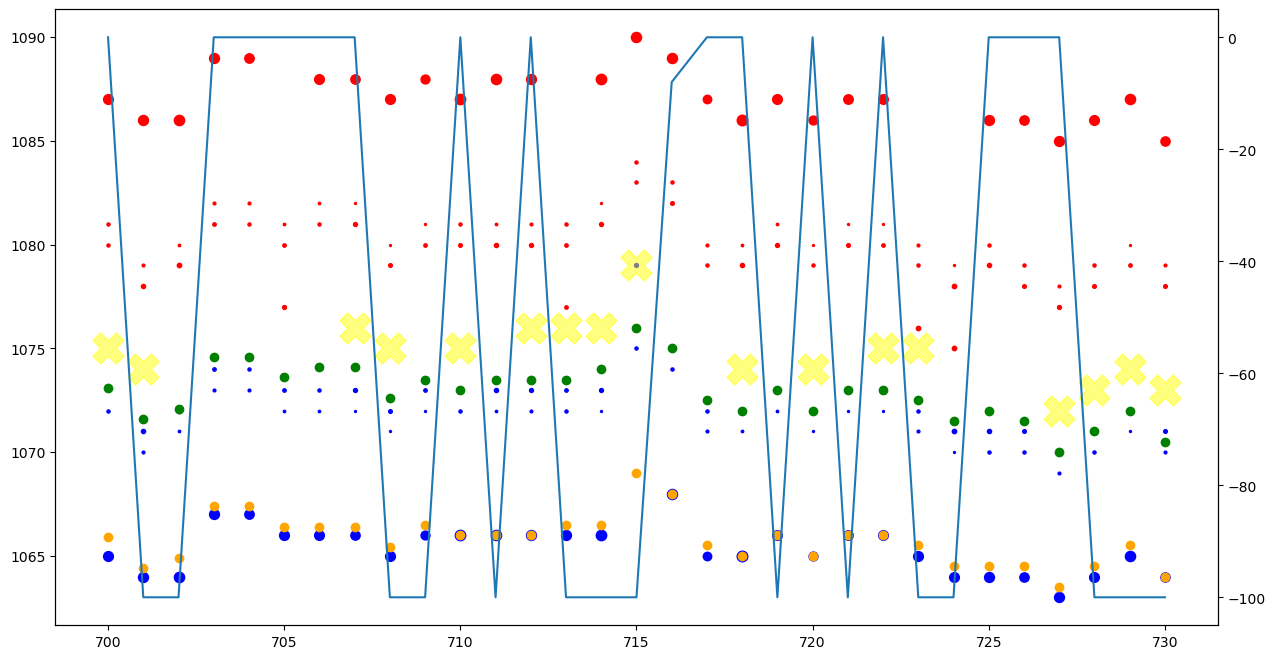

In [1211]:
product = "ORCHIDS"
filepath = r"/Users/ysc/Downloads/9eecb9a1-15d9-43ba-b873-093cbbf5a0cb.log"
M, N = 700, 730

####################################################################################
file = open(filepath)
o = file.read()
res = [None] * 1000
for i in range(1000):
    b = o.find("lambdaLog") + 13
    e = b + o[b:].find("\n") - 2
    # print(i)
    res[i] = jsonpickle.decode(o[b:e].replace("\\", ""))
    o = o[e:]
file.close()


class tradelog:
    def __init__(self, log):
        self._dict = log
    def __getattr__(self, w):
        return self._dict.get(w, "")

class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)
    log = [tradelog(l) for l in log_]

D_buy, D_sell, D_other = defaultdict(list), defaultdict(list), defaultdict(list)
cnt_buy = cnt_sell = 0
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell[l.timestamp // 100].append([l.price, l.quantity])
            cnt_sell += 1
        elif l.buyer == "SUBMISSION":
            D_buy[l.timestamp // 100].append([l.price, l.quantity])
            cnt_buy += 1
        else:
             D_other[l.timestamp // 100].append([l.price, l.quantity])
             

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price

with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]
with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df.iterrows():
      idx = row['timestamp'] // 100
      if idx < M:
            continue
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_
      dict_ = dict()
      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      order_depth_.sell_orders = dict_

    #   ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, v in D_sell.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=500)

for k, v in D_buy.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=500)


for i in range(M, N+1):

    ext_sell_price = res[i]['bidPrice'] - res[i]['transportFees'] - res[i]['exportTariff']
    ext_buy_price = res[i]['askPrice'] + res[i]['transportFees'] + res[i]['importTariff']
    ax.scatter(i, ext_buy_price, c='green')
    ax.scatter(i, ext_sell_price, c='orange')

pos = [r['position'] for r in res[M:N+1]]
ax2 = ax.twinx()
# ax2.plot([*range(M,N+1)], pos)

tf = [r['transportFees'] for r in res[M:N+1]]

ax2.plot([*range(M,N+1)], pos)
    

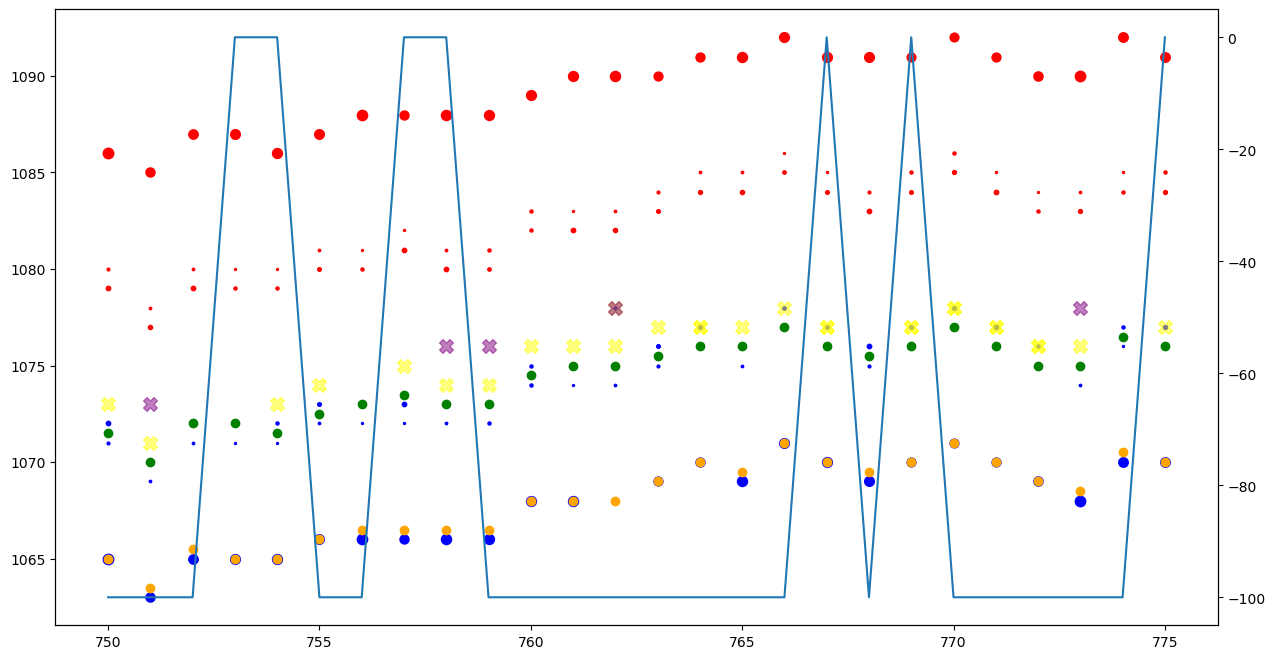

In [1202]:
product = "ORCHIDS"
filepath = r"/Users/ysc/Downloads/4cac7eba-c744-4e9c-bc1b-d14a8e6ad420.log"
M, N = 750, 775

####################################################################################
file = open(filepath)
o = file.read()
res = [None] * 1000
for i in range(1000):
    b = o.find("lambdaLog") + 13
    e = b + o[b:].find("\n") - 2
    # print(i)
    res[i] = jsonpickle.decode(o[b:e].replace("\\", ""))
    o = o[e:]
file.close()


class tradelog:
    def __init__(self, log):
        self._dict = log
    def __getattr__(self, w):
        return self._dict.get(w, "")

class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)
    log = [tradelog(l) for l in log_]

D_buy3, D_sell3, D_other3 = defaultdict(list), defaultdict(list), defaultdict(list)
cnt_buy = cnt_sell = 0
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell3[l.timestamp // 100].append([l.price, l.quantity])
            cnt_sell += 1
        elif l.buyer == "SUBMISSION":
            D_buy3[l.timestamp // 100].append([l.price, l.quantity])
            cnt_buy += 1
        else:
             D_other3[l.timestamp // 100].append([l.price, l.quantity])
             

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price

with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]
with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df.iterrows():
      idx = row['timestamp'] // 100
      if idx < M:
            continue
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_
      dict_ = dict()
      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      order_depth_.sell_orders = dict_

    #   ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, v in D_sell.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)

for k, v in D_buy.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)

for k, v in D_sell2.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='purple', marker='X', alpha=0.5, s=100)

for k, v in D_buy2.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='purple', marker='X', alpha=0.5, s=100)

for i in range(M, N+1):

    ext_sell_price = res[i]['bidPrice'] - res[i]['transportFees'] - res[i]['exportTariff']
    ext_buy_price = res[i]['askPrice'] + res[i]['transportFees'] + res[i]['importTariff']
    ax.scatter(i, ext_buy_price, c='green')
    ax.scatter(i, ext_sell_price, c='orange')

pos = [r['position'] for r in res[M:N+1]]
ax2 = ax.twinx()
# ax2.plot([*range(M,N+1)], pos)

tf = [r['transportFees'] for r in res[M:N+1]]

ax2.plot([*range(M,N+1)], pos)
    

In [1145]:
tmp = []

for k, v in D_sell.items():
    tmp += [v[0][0] - df.loc[k, "bid_price_3"]]

In [1073]:
pos = np.array([r['position'] for r in res])

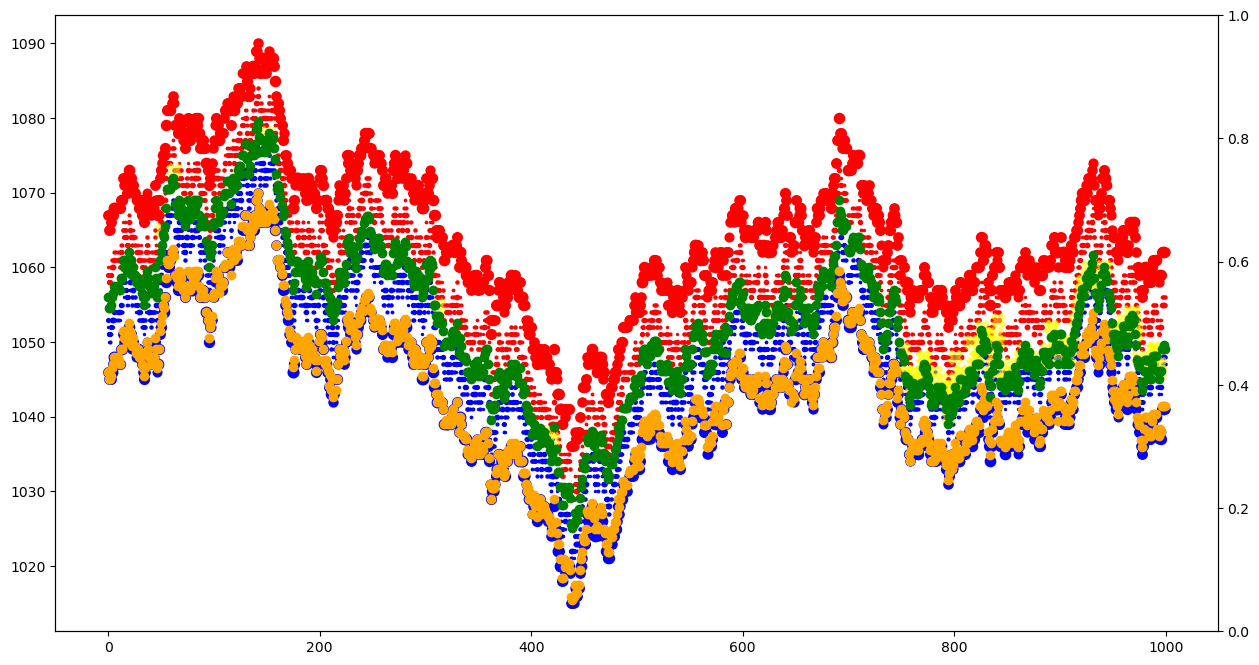

In [62]:
product = "ORCHIDS"
filepath = r"/Users/ysc/Downloads/benchmark_111.log"
M, N = 0, 999 

####################################################################################
file = open(filepath)
o = file.read()
res = [None] * 1000
for i in range(1000):
    b = o.find("lambdaLog") + 13
    e = b + o[b:].find("\n") - 2
    # print(i)
    res[i] = jsonpickle.decode(o[b:e].replace("\\", ""))
    o = o[e:]
file.close()


class tradelog:

    def __init__(self, log):
        self._dict = log
    def __getattr__(self, w):
        return self._dict.get(w, "")

class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)
    log = [tradelog(l) for l in log_]

D_buy3, D_sell3, D_other3 = defaultdict(list), defaultdict(list), defaultdict(list)
cnt_buy = cnt_sell = 0
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell3[l.timestamp // 100].append([l.price, l.quantity])
            cnt_sell += 1
        elif l.buyer == "SUBMISSION":
            D_buy3[l.timestamp // 100].append([l.price, l.quantity])
            cnt_buy += 1
        else:
             D_other3[l.timestamp // 100].append([l.price, l.quantity])
             

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price

with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]
with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df.iterrows():
      idx = row['timestamp'] // 100
      if idx < M:
            continue
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_
      dict_ = dict()
      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      order_depth_.sell_orders = dict_

    #   ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, v in D_sell3.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)

for k, v in D_buy3.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)


for i in range(M, N+1):

    ext_sell_price = res[i]['bidPrice'] - res[i]['transportFees'] - res[i]['exportTariff']
    ext_buy_price = res[i]['askPrice'] + res[i]['transportFees'] + res[i]['importTariff']
    ax.scatter(i, ext_buy_price, c='green')
    ax.scatter(i, ext_sell_price, c='orange')

pos = [r['position'] for r in res[M:N+1]]
ax2 = ax.twinx()
# ax2.plot([*range(M,N+1)], pos)

# ax2.plot([*range(M,N+1)], pos)
    

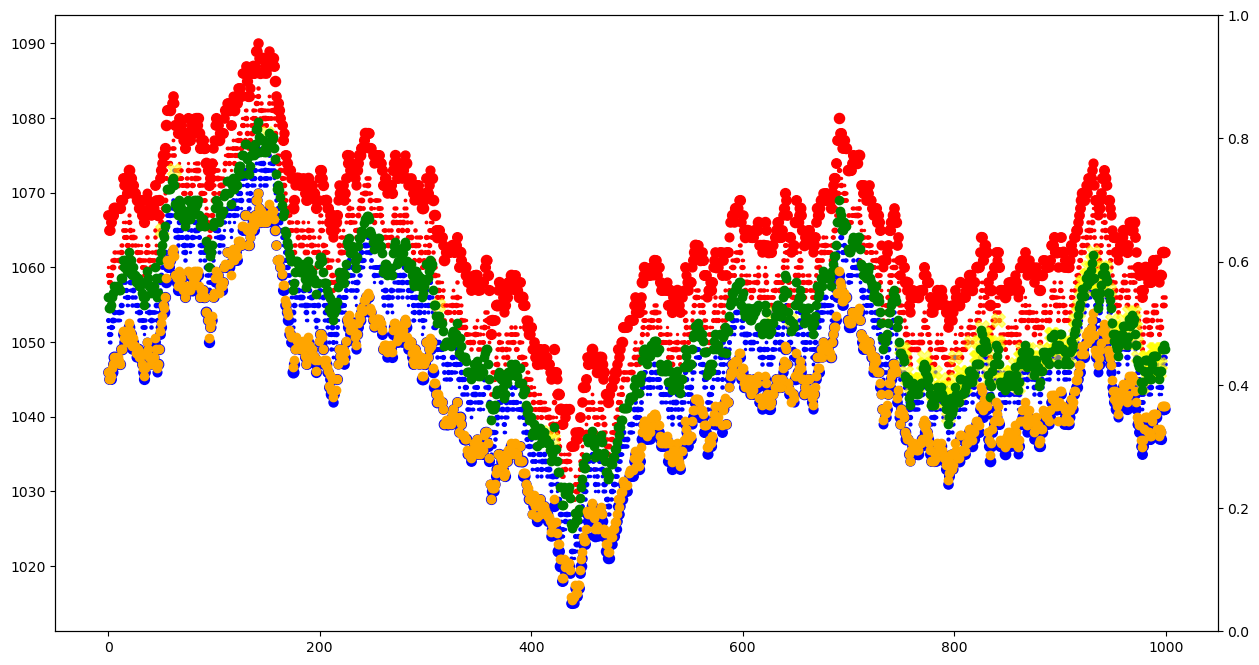

In [63]:
product = "ORCHIDS"
filepath = r"/Users/ysc/Downloads/benchmark_000.log"
M, N = 0, 999 

####################################################################################
file = open(filepath)
o = file.read()
res = [None] * 1000
for i in range(1000):
    b = o.find("lambdaLog") + 13
    e = b + o[b:].find("\n") - 2
    # print(i)
    res[i] = jsonpickle.decode(o[b:e].replace("\\", ""))
    o = o[e:]
file.close()


class tradelog:

    def __init__(self, log):
        self._dict = log
    def __getattr__(self, w):
        return self._dict.get(w, "")

class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)
    log = [tradelog(l) for l in log_]

D_buy0, D_sell0, D_other0 = defaultdict(list), defaultdict(list), defaultdict(list)
cnt_buy = cnt_sell = 0
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell0[l.timestamp // 100].append([l.price, l.quantity])
            cnt_sell += 1
        elif l.buyer == "SUBMISSION":
            D_buy0[l.timestamp // 100].append([l.price, l.quantity])
            cnt_buy += 1
        else:
             D_other0[l.timestamp // 100].append([l.price, l.quantity])
             

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price

with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]
with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df.iterrows():
      idx = row['timestamp'] // 100
      if idx < M:
            continue
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_
      dict_ = dict()
      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      order_depth_.sell_orders = dict_

    #   ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, v in D_sell0.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)

for k, v in D_buy0.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=100)


for i in range(M, N+1):

    ext_sell_price = res[i]['bidPrice'] - res[i]['transportFees'] - res[i]['exportTariff']
    ext_buy_price = res[i]['askPrice'] + res[i]['transportFees'] + res[i]['importTariff']
    ax.scatter(i, ext_buy_price, c='green')
    ax.scatter(i, ext_sell_price, c='orange')

pos = [r['position'] for r in res[M:N+1]]
ax2 = ax.twinx()
# ax2.plot([*range(M,N+1)], pos)

# ax2.plot([*range(M,N+1)], pos)
    

In [65]:
set(D_sell0.keys()) - set(D_sell3.keys())

{750,
 752,
 762,
 765,
 781,
 783,
 786,
 790,
 800,
 827,
 832,
 843,
 857,
 858,
 860,
 863,
 864,
 868,
 869,
 871,
 874,
 878,
 879,
 884,
 890,
 893,
 896,
 899,
 905,
 912,
 918,
 924,
 929,
 930,
 931,
 932,
 938,
 939,
 946,
 949,
 956,
 957,
 963,
 969,
 977,
 981,
 982}

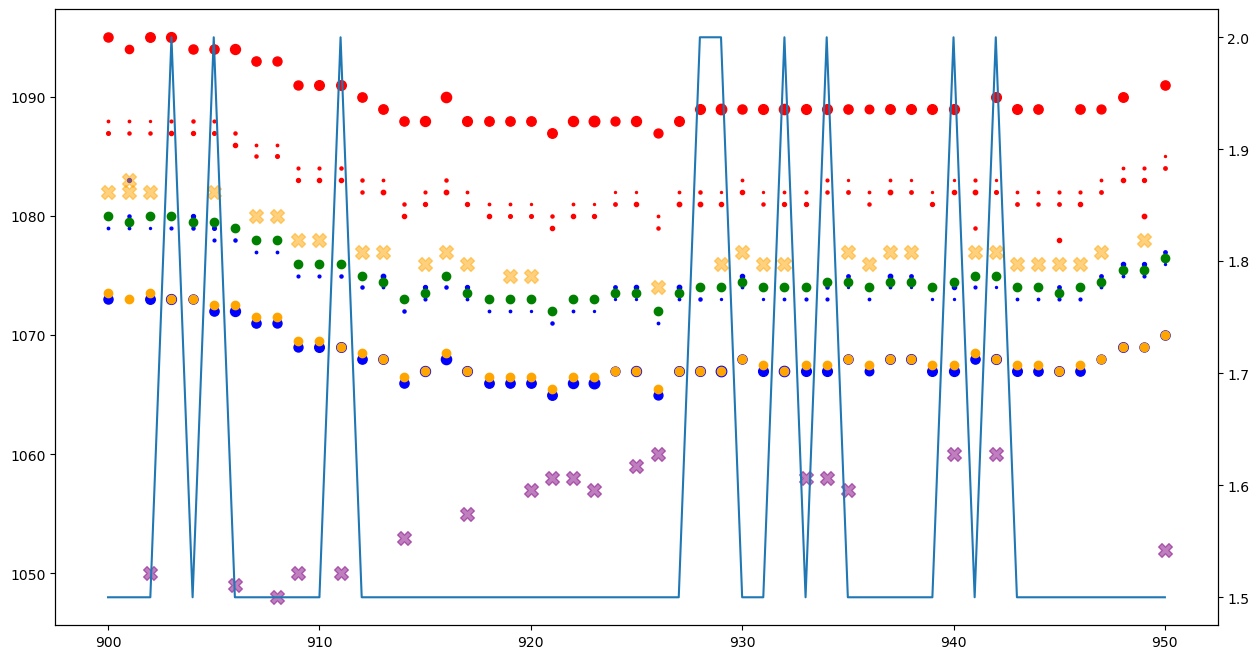

In [128]:
product = "ORCHIDS"
filepath = r"/Users/ysc/Downloads/benchmark_3.log"
M, N = 900, 950

####################################################################################
file = open(filepath)
o = file.read()
res = [None] * 1000
for i in range(1000):
    b = o.find("lambdaLog") + 13
    e = b + o[b:].find("\n") - 2
    # print(i)
    res[i] = jsonpickle.decode(o[b:e].replace("\\", ""))
    o = o[e:]
file.close()


class tradelog:

    def __init__(self, log):
        self._dict = log
    def __getattr__(self, w):
        return self._dict.get(w, "")

class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)
    log = [tradelog(l) for l in log_]

D_buy0, D_sell0, D_other0 = defaultdict(list), defaultdict(list), defaultdict(list)
cnt_buy = cnt_sell = 0
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell0[l.timestamp // 100].append([l.price, l.quantity])
            cnt_sell += 1
        elif l.buyer == "SUBMISSION":
            D_buy0[l.timestamp // 100].append([l.price, l.quantity])
            cnt_buy += 1
        else:
             D_other0[l.timestamp // 100].append([l.price, l.quantity])
             

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price

with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]
with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df.iterrows():
      idx = row['timestamp'] // 100
      if idx < M:
            continue
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_
      dict_ = dict()
      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      order_depth_.sell_orders = dict_

    #   ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, v in D_sell0.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='orange', marker='X', alpha=0.5, s=100)

for k, v in D_buy0.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='orange', marker='X', alpha=0.5, s=100)

for k, v in D_sell3.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='purple', marker='X', alpha=0.5, s=100)

for k, v in D_buy3.items():
      if k <= N and k >= M:
            for p, q in v:
                  ax.scatter(k, p, c='purple', marker='X', alpha=0.5, s=100)


for i in range(M, N+1):

    ext_sell_price = res[i]['bidPrice'] - res[i]['transportFees'] - res[i]['exportTariff']
    ext_buy_price = res[i]['askPrice'] + res[i]['transportFees'] + res[i]['importTariff']
    ax.scatter(i, ext_buy_price, c='green')
    ax.scatter(i, ext_sell_price, c='orange')

pos = [r['position'] for r in res[M:N+1]]
it = [r['importTariff'] for r in res[M:N+1]]
et = [r['exportTariff'] for r in res[M:N+1]]
bp = [r['bidPrice'] for r in res[M:N+1]]
ap = [r['askPrice'] for r in res[M:N+1]]
sp = [r['askPrice'] - r['bidPrice'] for r in res[M:N+1]]
humidity = [r['humidity'] for r in res[M:N+1]]
ax2 = ax.twinx()
ax2.plot([*range(M,N+1)], sp)

    

In [129]:
res_ = {}
for i in range(1000):
    if i in D_sell3:
        res_[i] = D_sell3[i][0][0]
    elif i in D_sell0:
        res_[i] = D_sell0[i][0][0]

(-5.0, 5.0)

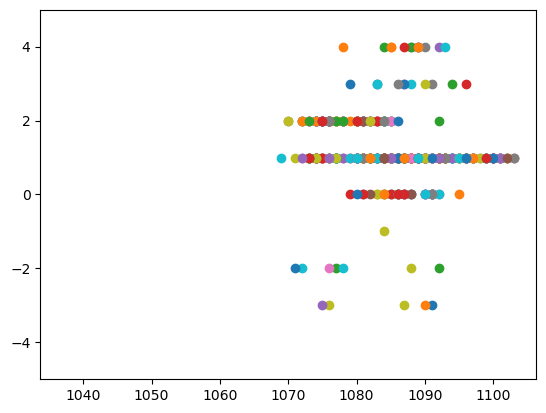

In [131]:
for k, v in res_.items():
    plt.scatter(v, int((df.loc[k, 'ask_price_3'] + df.loc[k, 'bid_price_3']) / 2) - v)
plt.ylim([-5, 5])

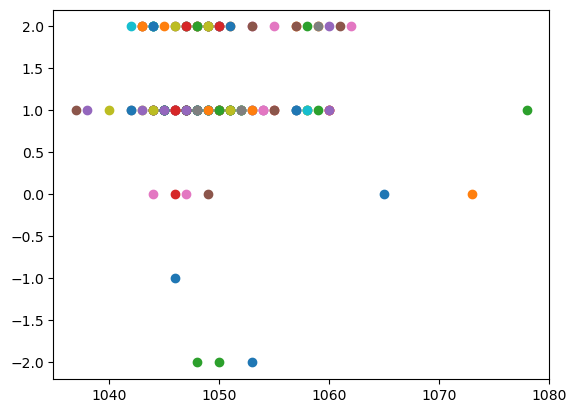

In [124]:
for k, v in res_.items():
    ext_buy_price = int(res[k]['askPrice'] + res[k]['transportFees'] + res[k]['importTariff'] + 1.5) + 1
    plt.scatter(v, ext_buy_price - v)

In [101]:
res

{51: 1065,
 62: 1073,
 150: 1078,
 312: 1055,
 417: 1038,
 421: 1037,
 628: 1054,
 646: 1053,
 750: 1049,
 751: 1049,
 752: 1048,
 754: 1046,
 755: 1046,
 759: 1044,
 760: 1045,
 761: 1046,
 762: 1044,
 763: 1045,
 764: 1044,
 765: 1044,
 767: 1045,
 768: 1046,
 769: 1046,
 770: 1048,
 771: 1048,
 772: 1047,
 775: 1046,
 776: 1045,
 780: 1043,
 781: 1042,
 782: 1046,
 783: 1043,
 786: 1044,
 787: 1045,
 788: 1044,
 790: 1043,
 791: 1044,
 792: 1042,
 794: 1040,
 797: 1044,
 799: 1042,
 800: 1043,
 801: 1048,
 802: 1044,
 804: 1043,
 805: 1046,
 806: 1046,
 808: 1044,
 809: 1044,
 810: 1045,
 811: 1045,
 813: 1046,
 816: 1050,
 817: 1046,
 818: 1047,
 820: 1048,
 821: 1048,
 822: 1048,
 824: 1050,
 826: 1052,
 827: 1049,
 828: 1051,
 829: 1051,
 830: 1051,
 831: 1050,
 832: 1046,
 833: 1046,
 836: 1047,
 837: 1048,
 839: 1051,
 841: 1053,
 843: 1045,
 845: 1045,
 847: 1046,
 849: 1045,
 853: 1047,
 854: 1046,
 857: 1047,
 858: 1046,
 860: 1044,
 862: 1048,
 863: 1048,
 864: 1049,
 865: 